# Imports

In [134]:
#Importar librerías necesarias para desarrollar el análisis
import importlib
import warnings

import pandas as pd
import numpy as np
import sklearn 
from sklearn.metrics import mean_squared_error, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer
import random as python_random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ks_2samp
import scorecardpy as sc
#import openpyxl

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_classif
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost

import sys
import notebook
import jupyterlab

import os
from pathlib import Path

In [135]:
from dotenv import load_dotenv, find_dotenv
# Carga el .env más cercano hacia arriba en el árbol
load_dotenv(find_dotenv())

# Raíz del proyecto = carpeta que contiene el .env
PROJECT_ROOT = Path(find_dotenv()).parent

# DATA_PATH puede ser relativo (./data) o absoluto; aquí lo resolvemos desde el root
DATA_PATH = (PROJECT_ROOT / os.environ.get("DATA_PATH", "data")).resolve()

In [136]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/Users/cristian/Documents/GitHub/adeslas-interview/.venv/bin/python
3.13.7


In [137]:
pd.set_option("display.max_columns", None)   # muestra todas las columnas
pd.set_option("display.width", 0)            # usa el ancho de la celda de Jupyter
pd.set_option("display.max_colwidth", None)  # no truncar el contenido de celdas

# Env

In [138]:
PROJ_ROOT = Path.cwd().parent 
sys.path.insert(0, str(PROJ_ROOT / "src"))


# Verifica
print("Añadido a sys.path:", sys.path[0])

from utils import feature_selection as fs

Añadido a sys.path: /Users/cristian/Documents/GitHub/adeslas-interview/src


# Funciones

# Load data

In [139]:
DATA_PATH = Path(os.environ["DATA_PATH"])

In [140]:
file_tab = DATA_PATH / "df_muestra_vars_eng.csv"
df_muestra_vars_eng = pd.read_csv(file_tab)
print(df_muestra_vars_eng.shape)



file_tab = DATA_PATH / "X_train.csv"
X_train = pd.read_csv(file_tab)
print(X_train.shape)

file_tab = DATA_PATH / "X_val.csv"
X_val = pd.read_csv(file_tab)
print(X_val.shape)

file_tab = DATA_PATH / "X_test.csv"
X_test = pd.read_csv(file_tab)
print(X_test.shape)



file_tab = DATA_PATH / "y_train.csv"
y_train = pd.read_csv(file_tab)
print(len(y_train))


file_tab = DATA_PATH / "y_val.csv"
y_val = pd.read_csv(file_tab)
print(len(y_val))


file_tab = DATA_PATH / "y_test.csv"
y_test = pd.read_csv(file_tab)
print(len(y_test))


selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str).tolist()
print(len(selected_vars))

(47547, 420)
(28528, 418)
(9510, 418)
(9509, 418)
28528
9510
9509
20


# Model - XGBoost con parametros estandar

In [141]:
# =========================
# Entrenamiento
# =========================
from utils.model_training import (
    train_xgb_binary,
    evaluate_model,
    save_artifacts,
    default_xgb_params,
)

# (Opcional) ajustar algunos hiperparámetros base
params = default_xgb_params() | dict(
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
)

results = train_xgb_binary(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_vars=selected_vars,
    xgb_params=params,
    early_stopping_rounds=100,
)

print("Best iteration:", results.best_iteration)
print("n_estimators efectivos:", results.best_n_estimators)
display(results.metrics)



Best iteration: 2
n_estimators efectivos: 3


,auc,ks,prauc,n
split,,,,
train,0.816360,0.484141,0.160692,28528
val,0.674062,0.268752,0.093998,9510


In [142]:

# =========================
# Evaluación en Test
# =========================
from utils.model_training import to_1d_series

X_te = X_test[[c for c in selected_vars if c in X_test.columns]].copy()
y_te = to_1d_series(y_test)

eval_test = evaluate_model(results.model, splits={"test": (X_te, y_te)})
print("\nMétricas test:")
display(eval_test)




Métricas test:


,auc,ks,prauc,n
split,,,,
test,0.661152,0.234796,0.088275,9509


In [143]:
# =========================
# Guardado de artefactos
# =========================
#ARTIF_PATH = DATA_PATH / "models"
#model_path, feats_path = save_artifacts(results, ARTIF_PATH)
#print(f"Modelo guardado en: {model_path}")
#print(f"Features usadas guardadas en: {feats_path}")


# Modelos - Pruebas

In [144]:
from utils import model_training as mt
importlib.reload(mt)  # asegura cargar la última versión del módulo


<module 'utils.model_training' from '/Users/cristian/Documents/GitHub/adeslas-interview/src/utils/model_training.py'>

## Preparacion de datos

In [145]:
# Alinear columnas con las seleccionadas
selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str)
use_cols = [c for c in selected_vars if c in X_train.columns]

X_tr, X_va, X_te = X_train[use_cols].copy(), X_val[use_cols].copy(), X_test[use_cols].copy()
y_tr = mt.to_1d_series(y_train)
y_va = mt.to_1d_series(y_val)
y_te = mt.to_1d_series(y_test)

# Desbalanceo (no lo usamos ahora, solo informativo)
pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
spw = max(1.0, neg / max(1, pos))
print(f"Class ratio -> pos={pos}, neg={neg}, scale_pos_weight≈{spw:.2f}")


Class ratio -> pos=571, neg=27957, scale_pos_weight≈48.96


In [146]:
splits={
    "train(refit)": (X_tr, y_tr),
    "val": (X_va, y_va),
    "test": (X_te, y_te),
}

for name, (_, y) in splits.items():
    tasa = y.mean()  # promedio = tasa de positivos
    print(f"{name}: tasa target = {tasa:.3%} ({y.sum()} de {len(y)})")


train(refit): tasa target = 2.002% (571 de 28528)
val: tasa target = 2.008% (191 de 9510)
test: tasa target = 1.998% (190 de 9509)


## Modelo 1 — Baseline (sin pesos, sin balanceo)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Baseline best params: {'colsample_bytree': np.float64(0.7542853455823514), 'gamma': np.float64(2.722699421778279), 'learning_rate': np.float64(0.021102634054601693), 'max_depth': 3, 'min_child_weight': 11, 'reg_alpha': np.float64(0.006490003020716538), 'reg_lambda': np.float64(30.731734742971184), 'subsample': np.float64(0.799432733244268)}


,auc,ks,prauc,n
split,,,,
test,0.695460,0.290985,0.121718,9509
train(refit),0.801388,0.441895,0.175221,28528
val,0.677368,0.261408,0.120014,9510


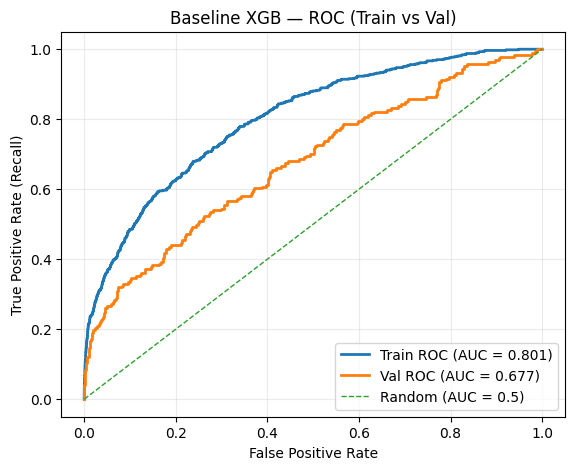

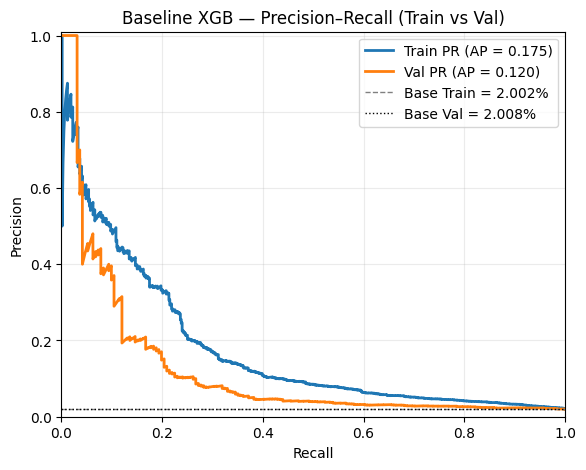

{'auc_train': 0.8013881964214871,
 'auc_val': 0.6773680298483815,
 'auc_gap': 0.12402016657310555,
 'prauc_train': 0.17522081860848776,
 'prauc_val': 0.12001417441289611,
 'prauc_gap': 0.05520664419559165,
 'prev_train': 0.020015423443634325,
 'prev_val': 0.020084121976866456}

In [147]:
rs_base = mt.randomized_search_xgb(
    X=X_tr, y=y_tr,
    base_params={},          # sin scale_pos_weight
    n_iter=40, 
    cv_splits=5,
    scoring="average_precision"
)
base_model = rs_base.best_estimator_
print("Baseline best params:", rs_base.best_params_)

res_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_base)

metrics_gap = mt.plot_curves_train_val(
    model=base_model,
    X_train=X_tr, y_train=y_tr,
    X_val=X_va,   y_val=y_va,
    title_prefix="Baseline XGB",
    show=True
)
metrics_gap


## Modelo 2 — Balanceado por undersampling de la clase 0

In [148]:
# =========================
# Undersampling 50/50 en TRAIN
# =========================
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Construyo un DF de trabajo con target
df_tr = X_tr.copy()
df_tr["target"] = y_tr

# Separo clases
df_pos = df_tr[df_tr["target"] == 1]
df_neg = df_tr[df_tr["target"] == 0]

n_pos = len(df_pos)
n_neg = len(df_neg)

if n_pos == 0:
    raise ValueError("No hay positivos en el set de entrenamiento.")
if n_neg == 0:
    raise ValueError("No hay negativos en el set de entrenamiento.")

# Undersample negativos hasta igualar a positivos (50/50)
df_neg_down = resample(
    df_neg,
    replace=False,
    n_samples=min(n_neg, n_pos),  # iguala a los positivos
    random_state=42,
)

# Conjunto balanceado 50/50
df_bal = pd.concat([df_pos, df_neg_down], axis=0).sample(frac=1.0, random_state=42)

X_tr_bal = df_bal.drop(columns="target")
y_tr_bal = df_bal["target"].astype(int)

print(
    f"Train original: pos={n_pos} ({n_pos/(n_pos+n_neg):.3%}), "
    f"neg={n_neg} ({n_neg/(n_pos+n_neg):.3%})"
)
print(
    f"Train balanceado: pos={int(y_tr_bal.sum())} "
    f"({y_tr_bal.mean():.3%}), neg={len(y_tr_bal)-int(y_tr_bal.sum())} "
    f"({1-y_tr_bal.mean():.3%})"
)


Train original: pos=571 (2.002%), neg=27957 (97.998%)
Train balanceado: pos=571 (50.000%), neg=571 (50.000%)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Balanced(50/50) best params: {'colsample_bytree': np.float64(0.6373608964950321), 'gamma': np.float64(1.6837302775431033), 'learning_rate': np.float64(0.03149193527717024), 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': np.float64(1.1044350847124695), 'reg_lambda': np.float64(1.1916467090032163), 'subsample': np.float64(0.8854835899772805)}


,auc,ks,prauc,n
split,,,,
test,0.680715,0.280535,0.092507,9509
train(refit-50/50),0.928009,0.695271,0.927489,1142
val,0.659003,0.242971,0.090401,9510


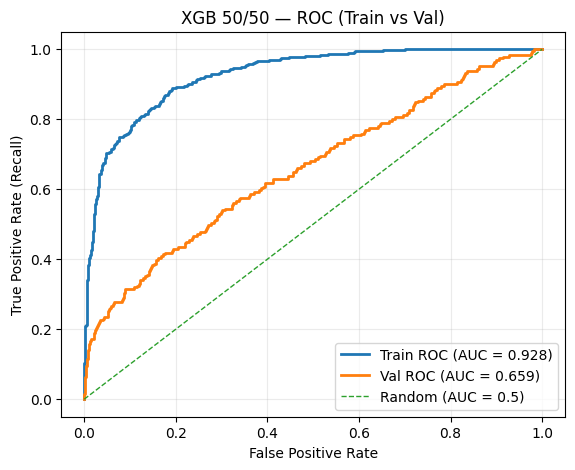

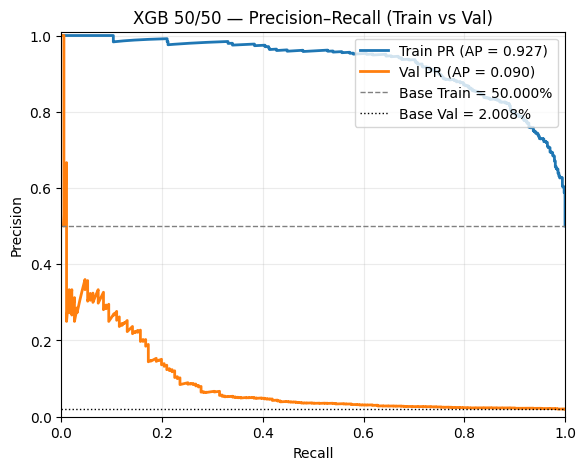

In [149]:
# =========================
# HPO en el set balanceado (PR-AUC)
# =========================
rs_bal50 = mt.randomized_search_xgb(
    X=X_tr_bal, y=y_tr_bal,
    base_params={},              # sin scale_pos_weight
    n_iter=40,                   # puedes subir a 80 si hay tiempo
    cv_splits=5,
    scoring="average_precision"
)
bal50_model = rs_bal50.best_estimator_
print("Balanced(50/50) best params:", rs_bal50.best_params_)

# =========================
# Evaluación en val/test (SIN balancear)
# =========================
res_bal50 = mt.evaluate_model(
    bal50_model,
    splits={
        "train(refit-50/50)": (X_tr_bal, y_tr_bal),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_bal50)


# =========================
# (Opcional) Curvas ROC/PR para ver overfitting del balanceado
# =========================
_ = mt.plot_curves_train_val(
    model=bal50_model,
    X_train=X_tr_bal, y_train=y_tr_bal,
    X_val=X_va,       y_val=y_va,
    title_prefix="XGB 50/50",
    show=True
)



## Write

In [150]:
import json
import joblib
import pandas as pd
from pathlib import Path

# --- rutas de salida
ART = DATA_PATH / "models"
ART.mkdir(parents=True, exist_ok=True)

# --- 1) Guardar modelos
path_base = ART / "xgb_baseline_rs.joblib"
path_bal  = ART / "xgb_balanced50_rs.joblib"
joblib.dump(base_model, path_base)
joblib.dump(bal50_model, path_bal)

['/Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_balanced50_rs.joblib']

In [151]:
# --- 2) Guardar features realmente usadas
(pd.Series(use_cols, name="feature")
   .to_csv(ART / "xgb_used_features.csv", index=False))

In [152]:
# --- 3) Guardar mejores hiperparámetros de cada búsqueda
with open(ART / "baseline_best_params.json", "w") as f:
    json.dump(rs_base.best_params_, f, indent=2)

with open(ART / "balanced50_best_params.json", "w") as f:
    json.dump(rs_bal50.best_params_, f, indent=2)

In [153]:
# --- 4) Métricas (AUC/KS/PR-AUC) en train/val/test

# Baseline
metrics_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val":          (X_va, y_va),
        "test":         (X_te, y_te),
    }
)
metrics_base.to_csv(ART / "metrics_baseline.csv")

In [154]:
# Balanced 50/50: usa el train balanceado si está disponible, sino solo val/test
try:
    _X_train_bal, _y_train_bal = X_tr_bal, y_tr_bal  # definidos si balanceaste 50/50 antes
    splits_bal = {
        "train(refit-50/50)": (_X_train_bal, _y_train_bal),
        "val":                (X_va, y_va),
        "test":               (X_te, y_te),
    }
except NameError:
    splits_bal = {
        "val":  (X_va, y_va),
        "test": (X_te, y_te),
    }

metrics_bal = mt.evaluate_model(bal50_model, splits=splits_bal)
metrics_bal.to_csv(ART / "metrics_balanced50.csv")

In [155]:
# --- 5) Resumen en pantalla
print("✔ Modelos guardados:")
print(f"  - Baseline:   {path_base}")
print(f"  - Balanced50: {path_bal}")
print("✔ Features guardadas en:", ART / "xgb_used_features.csv")
print("✔ HPO guardado en:", ART / "baseline_best_params.json", "y", ART / "balanced50_best_params.json")
print("✔ Métricas guardadas en:", ART / "metrics_baseline.csv", "y", ART / "metrics_balanced50.csv")






✔ Modelos guardados:
  - Baseline:   /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_baseline_rs.joblib
  - Balanced50: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_balanced50_rs.joblib
✔ Features guardadas en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_used_features.csv
✔ HPO guardado en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/baseline_best_params.json y /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/balanced50_best_params.json
✔ Métricas guardadas en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/metrics_baseline.csv y /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/metrics_balanced50.csv


## Evaluación comparativa (AUC / KS / PR-AUC)

In [156]:
def eval_all(models: dict[str, object]) -> pd.DataFrame:
    rows = []
    for name, model in models.items():
        res = mt.evaluate_model(model, splits={"val": (X_va, y_va)}).reset_index()
        res["model"] = name
        rows.append(res)
    out = pd.concat(rows, ignore_index=True)
    return out.pivot(index="model", columns="split", values=["auc","ks","prauc"])

models = {
    "baseline": base_model,
     #"spw": spw_model,        # descomenta si lo entrenas
    "balanced": bal50_model,
}
display(eval_all(models))


,auc,ks,prauc
split,val,val,val
model,,,
balanced,0.659003,0.242971,0.090401
baseline,0.677368,0.261408,0.120014


# SHAP

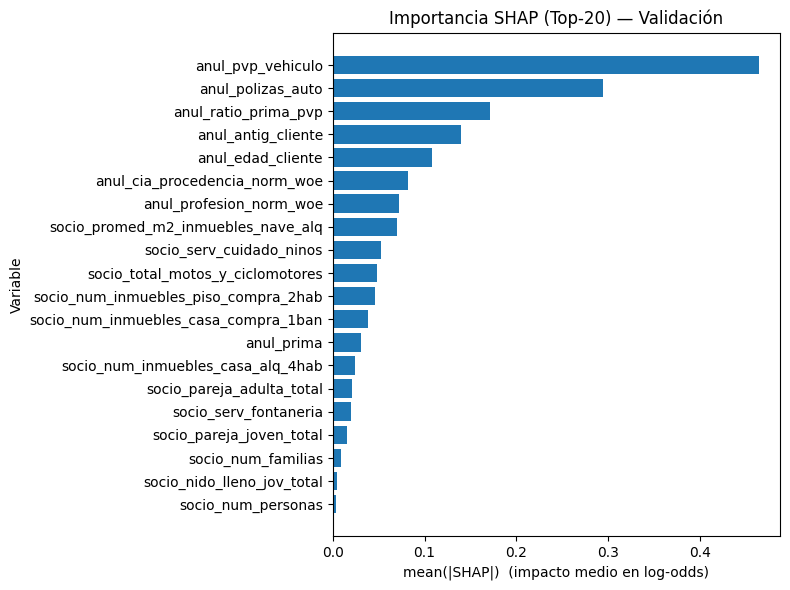

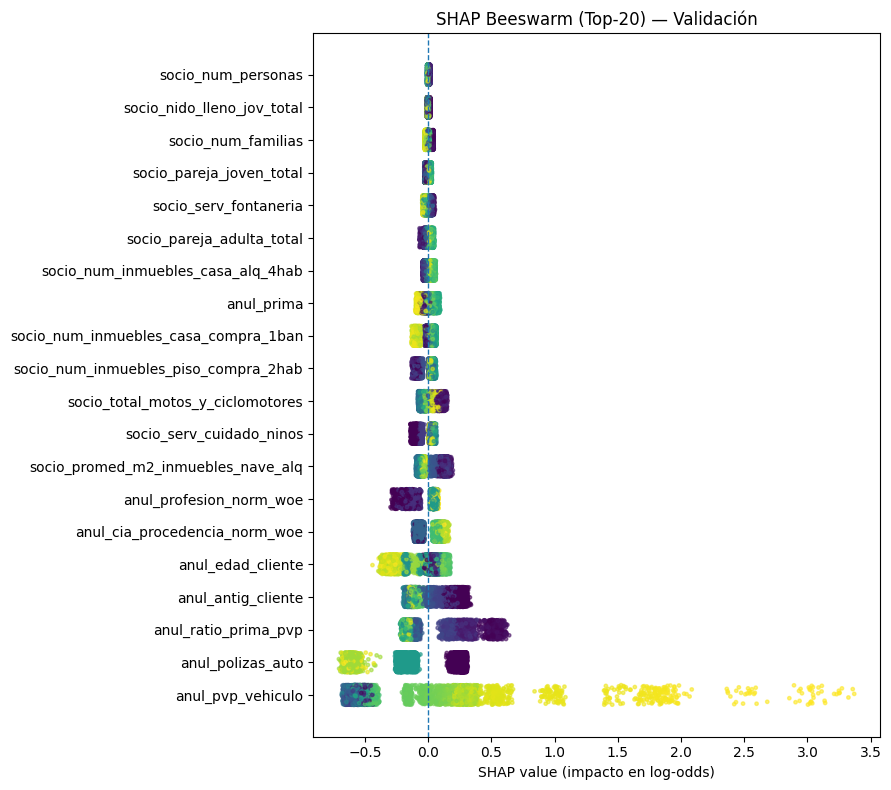

• Bar plot: mean(|SHAP|) mayor ⇒ mayor impacto global en el score.
• Beeswarm: puntos a la derecha (SHAP > 0) empujan a mayor prob. de anulación; a la izquierda (SHAP < 0) reducen.
• El color indica el valor relativo de la feature (percentil bajo→oscuro, alto→claro). Observa si valores altos/ bajos empujan positivamente o negativamente.


In [157]:
# =========================================
# Plots "típicos" de SHAP (sin librería shap)
# - Bar: mean(|SHAP|) por feature (top_k)
# - Beeswarm: dispersión de SHAP por feature (top_k), color por valor
# Requiere: base_model, X_va
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# 1) Alinear orden de columnas con el booster
booster = base_model.get_booster()
feat_order = booster.feature_names
Xv_ord = X_va[feat_order].copy()

# 2) SHAP values por observación (contribuciones); última col es el bias -> la quitamos
shap_all = booster.predict(xgb.DMatrix(Xv_ord), pred_contribs=True)  # (n, p+1)
shap_vals = shap_all[:, :-1]                                        # (n, p)
shap_df = pd.DataFrame(shap_vals, columns=feat_order)

# 3) Importancias: mean(|SHAP|)
imp = (np.abs(shap_vals).mean(axis=0))
imp_df = pd.DataFrame({"feature": feat_order, "mean_abs_shap": imp}) \
           .sort_values("mean_abs_shap", ascending=False, kind="mergesort") \
           .reset_index(drop=True)

# =========================
# Plot 1: Bar de importancias
# =========================
top_k = 20  # ajusta si quieres más/menos
imp_top = imp_df.head(top_k).iloc[::-1]  # invertimos para que la mayor quede arriba
plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"], imp_top["mean_abs_shap"])
plt.xlabel("mean(|SHAP|)  (impacto medio en log-odds)")
plt.ylabel("Variable")
plt.title(f"Importancia SHAP (Top-{top_k}) — Validación")
plt.tight_layout()
plt.show()

# =========================
# Plot 2: Beeswarm "tipo SHAP"
# =========================
# Construimos un beeswarm simple: para cada feature, graficamos sus SHAP con jitter vertical,
# y coloreamos por el valor de la feature (normalizado a percentiles).
def _percentile_scale(x: np.ndarray) -> np.ndarray:
    # escalar a [0,1] por percentiles para color
    ranks = pd.Series(x).rank(pct=True).to_numpy()
    return ranks

top_feats = imp_df["feature"].head(top_k).tolist()
shap_sub = shap_df[top_feats].to_numpy()
val_sub  = Xv_ord[top_feats].to_numpy()

# eje Y: índice de feature (0..top_k-1)
ypos = np.arange(len(top_feats))

plt.figure(figsize=(9, 8))
for i, f in enumerate(top_feats):
    sv = shap_sub[:, i]
    xv = val_sub[:, i]
    # jitter vertical para no superponer puntos
    jitter = (np.random.rand(len(sv)) - 0.5) * 0.6
    y = np.full_like(sv, fill_value=i, dtype=float) + jitter

    # color por percentil del valor de la feature (bajo=oscuro, alto=claro por colormap default)
    c = _percentile_scale(xv)

    plt.scatter(sv, y, s=6, alpha=0.6, c=c)  # sin especificar cmap → usa default

plt.yticks(ticks=ypos, labels=top_feats)
plt.xlabel("SHAP value (impacto en log-odds)")
plt.title(f"SHAP Beeswarm (Top-{top_k}) — Validación")
plt.axvline(0.0, ls="--", lw=1)
plt.tight_layout()
plt.show()

# ===== Tips de lectura impresos =====
print("• Bar plot: mean(|SHAP|) mayor ⇒ mayor impacto global en el score.")
print("• Beeswarm: puntos a la derecha (SHAP > 0) empujan a mayor prob. de anulación; a la izquierda (SHAP < 0) reducen.")
print("• El color indica el valor relativo de la feature (percentil bajo→oscuro, alto→claro). Observa si valores altos/ bajos empujan positivamente o negativamente.")


In [158]:
# ====== FIX SHAP: usar el MISMO orden de features que en entrenamiento ======
import xgboost as xgb
import numpy as np
import pandas as pd

from utils import model_training as mt
import importlib; importlib.reload(mt)

# 1) Obtener el orden correcto desde el booster
booster = base_model.get_booster()
feat_order = booster.feature_names  # orden usado al entrenar

# 2) Reordenar X_val con ese orden
Xv_ord = X_va[feat_order].copy()

# 3) SHAP importancias e interacciones agregadas (ya ordenado)
imp, inter = mt.shap_contribs(model=base_model, X=Xv_ord)
print("Top-10 por |SHAP| medio (val):")
display(imp.head(10))

top3_feats = imp["feature"].head(3).tolist()
print("Top-3 features:", top3_feats)

# 4) Obtener SHAP por observación (contribuciones) respetando el orden
dval = xgb.DMatrix(Xv_ord)  # MISMO ORDEN que feat_order
shap_all = booster.predict(dval, pred_contribs=True)  # (n, p+1)
shap_df = pd.DataFrame(shap_all[:, :-1], columns=feat_order)  # quitar bias, mismo orden

# 5) Perfil por cuantiles y dirección del efecto para cada top feature
from scipy.stats import spearmanr

def feature_shap_profile(X: pd.DataFrame, shap_df: pd.DataFrame, feat: str, q: int = 5) -> dict:
    df = pd.DataFrame({"value": X[feat].values, "shap": shap_df[feat].values}).dropna()
    df["q"] = pd.qcut(df["value"], q=q, duplicates="drop")
    tab = (df.groupby("q")
             .agg(value_mean=("value","mean"),
                  shap_mean=("shap","mean"),
                  shap_abs_mean=("shap", lambda s: np.mean(np.abs(s))),
                  n=("value","size"))
             .reset_index())
    rho, pval = spearmanr(df["value"], df["shap"])
    mean_low, mean_high = tab["shap_mean"].iloc[0], tab["shap_mean"].iloc[-1]
    if mean_high > mean_low:
        direction = "↑ valor → ↑ riesgo (SHAP ↑)"
    elif mean_high < mean_low:
        direction = "↑ valor → ↓ riesgo (SHAP ↓)"
    else:
        direction = "Efecto plano/no direccional"
    return {"table": tab, "rho": rho, "pval": pval, "direction": direction}

profiles = {}
for f in top3_feats:
    profiles[f] = feature_shap_profile(Xv_ord, shap_df, f, q=5)
    print(f"\n=== {f} ===")
    print(f"Dirección: {profiles[f]['direction']} | Spearman rho={profiles[f]['rho']:.3f} (p≈{profiles[f]['pval']:.1e})")
    display(profiles[f]["table"])

# 6) Interacciones (si tu build lo soporta)
if not inter.empty:
    print("\nTop-10 interacciones por |SHAP| medio (val):")
    display(inter.head(10))
    inter_top = inter[inter["feat_i"].isin(top3_feats) | inter["feat_j"].isin(top3_feats)].head(5)
    print("\nInteracciones que involucran top-3:")
    display(inter_top)

    # Tensor de interacciones usando el MISMO ORDEN
    inter_tensor = booster.predict(xgb.DMatrix(Xv_ord), pred_interactions=True)  # (n, p+1, p+1)
    inter_tensor = inter_tensor[:, :-1, :-1]
    col2idx = {c:i for i,c in enumerate(feat_order)}

    def interaction_2x2_summary(X: pd.DataFrame, shap_inter: np.ndarray, i: str, j: str) -> pd.DataFrame:
        mi, mj = X[i].median(), X[j].median()
        LL = (X[i] <= mi) & (X[j] <= mj)
        LH = (X[i] <= mi) & (X[j] >  mj)
        HL = (X[i] >  mi) & (X[j] <= mj)
        HH = (X[i] >  mi) & (X[j] >  mj)
        return pd.DataFrame({
            "low/low":  [float(np.mean(shap_inter[LL]))],
            "low/high": [float(np.mean(shap_inter[LH]))],
            "high/low": [float(np.mean(shap_inter[HL]))],
            "high/high":[float(np.mean(shap_inter[HH]))],
        }, index=[f"{i}×{j} | mean interaction SHAP"])

    print("\nResumen 2x2 (low/high por mediana) para interacciones top:")
    for _, row in inter_top.iterrows():
        i, j = row["feat_i"], row["feat_j"]
        ii, jj = col2idx[i], col2idx[j]
        pair_inter = inter_tensor[:, ii, jj]
        display(interaction_2x2_summary(Xv_ord, pair_inter, i, j))
else:
    print("\n(pred_interactions no disponible en esta build)")

print("\n--- Guía de lectura ---")
print("* SHAP > 0 empuja a mayor prob. de anulación; SHAP < 0 reduce la prob.")
print("* Tabla por cuantiles: compara SHAP medio en low→high para ver dirección.")
print("* Spearman ρ indica monotonicidad del efecto.")
print("* Interacciones 2x2: combinaciones low/high que elevan o mitigan riesgo.")


Top-10 por |SHAP| medio (val):


,feature,mean_abs_shap
0,anul_pvp_vehiculo,0.463621
1,anul_polizas_auto,0.294635
2,anul_ratio_prima_pvp,0.170953
3,anul_antig_cliente,0.140097
4,anul_edad_cliente,0.108567
5,anul_cia_procedencia_norm_woe,0.082038
6,anul_profesion_norm_woe,0.072300
7,socio_promed_m2_inmuebles_nave_alq,0.069926
8,socio_serv_cuidado_ninos,0.052427
9,socio_total_motos_y_ciclomotores,0.047801


Top-3 features: ['anul_pvp_vehiculo', 'anul_polizas_auto', 'anul_ratio_prima_pvp']

=== anul_pvp_vehiculo ===
Dirección: ↑ valor → ↑ riesgo (SHAP ↑) | Spearman rho=0.687 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(0.822, 2866.007]",1417.558775,-0.535018,0.535018,1639
1,"(2866.007, 5786.998]",4262.644006,-0.586698,0.586698,1639
2,"(5786.998, 9177.017]",7442.421265,-0.547409,0.547409,1638
3,"(9177.017, 14096.303]",11415.242478,-0.399897,0.410876,1639
4,"(14096.303, 75734.904]",19930.467163,0.576001,0.576001,1639



=== anul_polizas_auto ===
Dirección: ↑ valor → ↓ riesgo (SHAP ↓) | Spearman rho=-0.917 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(-0.001, 1.0]",0.423439,0.069434,0.229363,7850
1,"(1.0, 5.0]",2.304819,-0.603296,0.603296,1660



=== anul_ratio_prima_pvp ===
Dirección: ↑ valor → ↓ riesgo (SHAP ↓) | Spearman rho=-0.767 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(-0.00099786, 0.0137]",0.007369,0.327249,0.327249,1639
1,"(0.0137, 0.0302]",0.021461,-0.084170,0.113147,1639
2,"(0.0302, 0.0587]",0.042808,-0.165109,0.165109,1638
3,"(0.0587, 0.132]",0.087044,-0.168769,0.168769,1639
4,"(0.132, 690.004]",1.422776,-0.162549,0.162549,1639



Top-10 interacciones por |SHAP| medio (val):


,feat_i,feat_j,mean_abs_interaction
0,anul_pvp_vehiculo,anul_polizas_auto,0.027105
1,anul_pvp_vehiculo,anul_cia_procedencia_norm_woe,0.011611
2,anul_pvp_vehiculo,anul_profesion_norm_woe,0.009306
3,anul_pvp_vehiculo,anul_antig_cliente,0.007751
4,anul_pvp_vehiculo,anul_edad_cliente,0.006790
5,anul_polizas_auto,anul_edad_cliente,0.006624
6,anul_antig_cliente,socio_promed_m2_inmuebles_nave_alq,0.006537
7,anul_cia_procedencia_norm_woe,anul_edad_cliente,0.006387
8,anul_polizas_auto,anul_prima,0.006189
9,anul_polizas_auto,anul_antig_cliente,0.006062



Interacciones que involucran top-3:


,feat_i,feat_j,mean_abs_interaction
0,anul_pvp_vehiculo,anul_polizas_auto,0.027105
1,anul_pvp_vehiculo,anul_cia_procedencia_norm_woe,0.011611
2,anul_pvp_vehiculo,anul_profesion_norm_woe,0.009306
3,anul_pvp_vehiculo,anul_antig_cliente,0.007751
4,anul_pvp_vehiculo,anul_edad_cliente,0.006790



Resumen 2x2 (low/high por mediana) para interacciones top:


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_polizas_auto | mean interaction SHAP,-0.001587,-0.001359,0.00031,-0.003704


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_cia_procedencia_norm_woe | mean interaction SHAP,-0.014259,0.017474,-0.001952,0.002428


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_profesion_norm_woe | mean interaction SHAP,0.002046,-0.006043,-0.000109,0.00132


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_antig_cliente | mean interaction SHAP,0.005176,-0.005005,0.001149,-0.002317


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_edad_cliente | mean interaction SHAP,0.00557,-0.005462,0.001455,-0.001868



--- Guía de lectura ---
* SHAP > 0 empuja a mayor prob. de anulación; SHAP < 0 reduce la prob.
* Tabla por cuantiles: compara SHAP medio en low→high para ver dirección.
* Spearman ρ indica monotonicidad del efecto.
* Interacciones 2x2: combinaciones low/high que elevan o mitigan riesgo.


# Interpretación de factores principales de fuga

## 1. Clientes con vehículos de mayor valor (`anul_pvp_vehiculo`)
- A medida que sube el precio del vehículo, la probabilidad de anulación también aumenta.  
- **Perfil típico**: clientes con coches de gama media/alta son más sensibles al precio y tienden a comparar más.  

## 2. Clientes con varias pólizas de auto (`anul_polizas_auto`)
- Tener más de una póliza de auto reduce fuertemente la probabilidad de fuga.  
- **Perfil típico**: familias o particulares con más de un vehículo asegurado muestran **mayor fidelidad** y menor propensión a cancelar.  

## 3. Relación prima/PVP vehículo (`anul_ratio_prima_pvp`)
- Si la prima es percibida como proporcionada al valor del vehículo, el riesgo de fuga es menor.  
- Cuando el ratio es extremadamente bajo o inconsistente, se asocia a más riesgo (posible señal de pólizas menos rentables o clientes poco comprometidos).  

---

## Interacciones relevantes

- **Vehículo caro × aseguradora de origen (`anul_cia_procedencia_norm_woe`)**  
  - El efecto del precio del vehículo se modula según la aseguradora de la que proviene el cliente.  
  - Los clientes procedentes de compañías con WOE alto (históricamente más riesgosas) y con vehículos caros muestran mayor propensión a cancelar.  

- **Vehículo caro × profesión (`anul_profesion_norm_woe`)**  
  - El efecto del precio del vehículo se modula según la profesión del cliente.  
  - Profesiones con WOE alto (más propensas a fuga) amplifican el riesgo en clientes con vehículos caros.  

---

## Conclusión para negocio

- **Mayor riesgo**: clientes con **vehículos caros**, **una sola póliza**, y que además pertenecen a **aseguradoras de origen o profesiones con WOE alto**.  
- **Menor riesgo**: clientes **multipóliza**, con **vehículos de valor medio**, y primas ajustadas a su PVP.  
- **Acción recomendada**:  
  - Focalizar campañas de retención en **clientes de alto valor de vehículo que solo tengan 1 póliza**.  
  - Reforzar programas de fidelización multiproducto (beneficios a clientes con más de una póliza).  
  - Considerar el **origen de la aseguradora** y la **profesión** como moduladores del riesgo al priorizar a quién ofrecer incentivos.  


# Métricas utilizadas para evaluar el modelo

Para determinar si el modelo de XGBoost es apropiado en la predicción de la fuga de clientes, hemos utilizado un conjunto de métricas complementarias:

## 1. AUC-ROC (Área bajo la curva ROC)
- **Qué mide**: capacidad global de discriminación del modelo entre clientes que cancelan (churn) y los que no.  
- **Interpretación**: valores >0.65 ya indican poder predictivo razonable; un modelo aleatorio tendría AUC≈0.50.  
- **Uso**: garantiza que el modelo rankea a los clientes de forma útil a lo largo de todo el espectro de umbrales.

## 2. KS Statistic (Kolmogorov-Smirnov)
- **Qué mide**: máxima separación entre la distribución acumulada de positivos (churners) y negativos (no churners).  
- **Interpretación**: cuanto mayor el KS, mejor capacidad de separación. Valores >0.2 son aceptables en riesgo/retención.  
- **Uso**: métrica clásica en scoring de clientes, fácil de explicar a negocio.

## 3. PR-AUC (Área bajo la curva Precision-Recall)
- **Qué mide**: calidad de la predicción enfocada en la **clase minoritaria** (clientes que cancelan).  
- **Interpretación**: es crítica en contextos de desbalanceo severo; un clasificador aleatorio tendría PR-AUC≈%churn (ej: si churn=2%, PR-AUC≈0.02).  
- **Uso**: nos permite validar que el modelo realmente concentra churners en los primeros percentiles de score.

---

## Conclusión
- **AUC** y **KS** muestran que el modelo generaliza y discrimina mejor que el azar.  
- **PR-AUC** confirma que, a pesar del desbalanceo, el modelo concentra churners en los percentiles altos.  
- Al definir umbrales, se monitorizarán **precision**, **recall** y **Fβ**, que permiten alinear el uso del modelo con los objetivos de negocio (minimizar gasto en incentivos vs maximizar retención).  


# Calibracion - revision

In [159]:
# =========================================
# PASO 1 — Calibración sencilla (isotónica, prefit)
# - No reentrena el XGBoost; reserva 20% de TRAIN como set de calibración
# =========================================
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedShuffleSplit
from utils import model_training as mt

# Split de calibración (20% de TRAIN)
y_tr_1d = mt.to_1d_series(y_tr)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx_fit, idx_cal = next(sss.split(X_tr, y_tr_1d))
X_cal, y_cal = X_tr.iloc[idx_cal], y_tr_1d.iloc[idx_cal]

# Calibrador isotónico sobre el modelo ya entrenado (base_model)
calibrated_clf = CalibratedClassifierCV(estimator=base_model, method="isotonic", cv="prefit")
calibrated_clf.fit(X_cal, y_cal)

# Probabilidades calibradas en VALIDACIÓN y TEST
p_val_cal = calibrated_clf.predict_proba(X_va)[:, 1]
p_test_cal = calibrated_clf.predict_proba(X_te)[:, 1]
print("Hecho: probabilidades calibradas en val/test listas (p_val_cal, p_test_cal).")


Hecho: probabilidades calibradas en val/test listas (p_val_cal, p_test_cal).


        set  prevalence  p_mean     AUC   Brier  LogLoss     ECE  CalibSlope  \
0   VAL_raw      0.0201  0.0195  0.6774  0.0188   0.0913  0.0018      0.8522   
1   VAL_cal      0.0201  0.0197  0.6733  0.0193   0.1335  0.0056      0.0524   
2  TEST_raw      0.0200  0.0192  0.6955  0.0186   0.0899  0.0020      0.8951   
3  TEST_cal      0.0200  0.0193  0.6901  0.0186   0.1307  0.0024      0.0554   

   CalibIntercept  
0         -0.4888  
1         -3.5107  
2         -0.3266  
3         -3.4965  


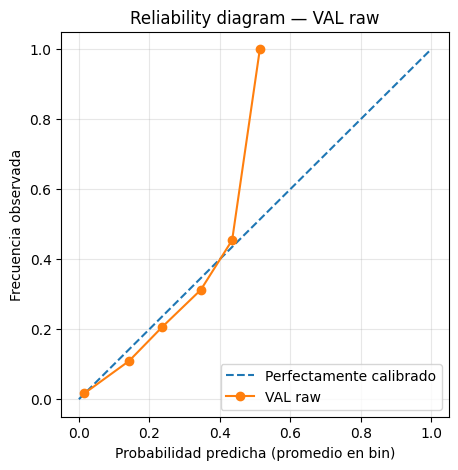

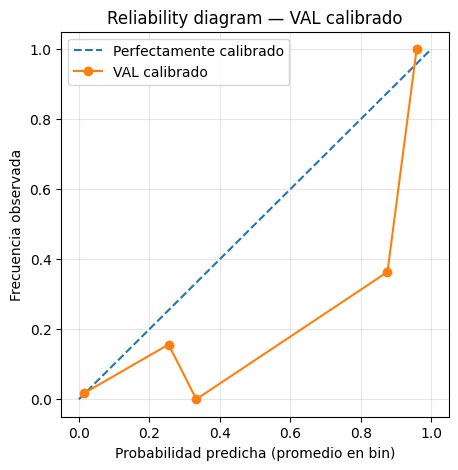

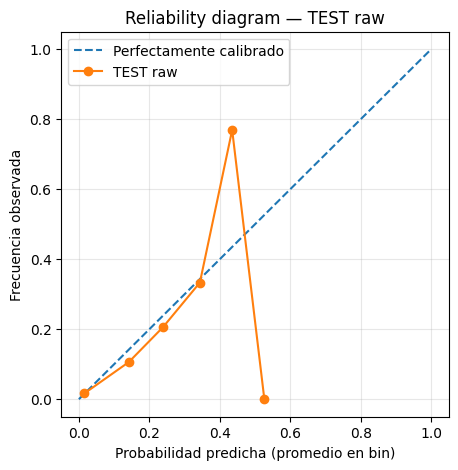

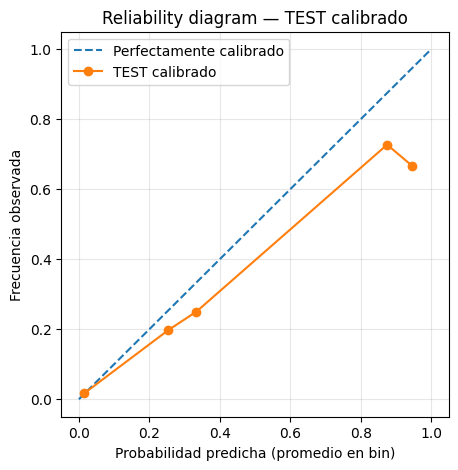

VAL: prevalencia=0.0201 | mean(p_raw)=0.0195 | mean(p_cal)=0.0197
TEST: prevalencia=0.0200 | mean(p_raw)=0.0192 | mean(p_cal)=0.0193
ΔAUC VAL=-0.0041 | ΔAUC TEST=-0.0054 (esperable ≈ 0 o leve ↓)
ΔBrier VAL=+0.0005
ΔBrier TEST=+0.0000


In [160]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0) Probabilidades SIN calibrar (del modelo base ya entrenado)
# ---------------------------------------------------------------------
p_val_raw  = base_model.predict_proba(X_va)[:, 1]
p_test_raw = base_model.predict_proba(X_te)[:, 1]

# Ya tienes: p_val_cal, p_test_cal (calibradas)

# ---------------------------------------------------------------------
# 1) Métricas clave y utilidades
# ---------------------------------------------------------------------
def expected_calibration_error(y_true: np.ndarray, p_pred: np.ndarray, n_bins: int = 10) -> float:
    """ECE (L1 por bins estratificados en probabilidad)."""
    prob_true, prob_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="uniform")
    # Pesos por tamaño de cada bin
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(p_pred, bins) - 1
    w = np.bincount(idx, minlength=n_bins).astype(float)
    w = w / (w.sum() + 1e-12)
    # Asegura longitudes compatibles
    m = min(len(prob_true), len(w))
    return float(np.sum(w[:m] * np.abs(prob_true[:m] - prob_pred[:m])))

def calib_slope_intercept(y_true: np.ndarray, p_pred: np.ndarray) -> tuple[float, float]:
    """Calibration-in-the-large (intercept) y calibration slope vía regresión logística de y ~ logit(p).
    Ideal: intercept≈0, slope≈1.
    """
    eps = 1e-15
    p = np.clip(p_pred, eps, 1 - eps)
    logit = np.log(p / (1 - p)).reshape(-1, 1)
    # Intercepto libre
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit, y_true)
    slope = float(lr.coef_.ravel()[0])
    intercept = float(lr.intercept_.ravel()[0])
    return slope, intercept

def summary_metrics(y_true: np.ndarray, p: np.ndarray, label: str, n_bins: int = 10) -> dict:
    slope, intercept = calib_slope_intercept(y_true, p)
    return {
        "set": label,
        "prevalence": float(np.mean(y_true)),
        "p_mean": float(np.mean(p)),
        "AUC": float(roc_auc_score(y_true, p)),
        "Brier": float(brier_score_loss(y_true, p)),
        "LogLoss": float(log_loss(y_true, np.clip(p, 1e-15, 1-1e-15))),
        "ECE": float(expected_calibration_error(y_true, p, n_bins=n_bins)),
        "CalibSlope": slope,
        "CalibIntercept": intercept,
    }

# ---------------------------------------------------------------------
# 2) Comparativa antes vs después (VALIDACIÓN y TEST)
# ---------------------------------------------------------------------
rows = []
rows.append(summary_metrics(y_va, p_val_raw,  "VAL_raw"))
rows.append(summary_metrics(y_va, p_val_cal,  "VAL_cal"))
rows.append(summary_metrics(y_te, p_test_raw, "TEST_raw"))
rows.append(summary_metrics(y_te, p_test_cal, "TEST_cal"))
df_report = pd.DataFrame(rows)
print(df_report.round(4))

# ---------------------------------------------------------------------
# 3) Reliability diagrams (VAL y TEST)
# ---------------------------------------------------------------------
def plot_reliability(y_true, p_pred, title: str, n_bins: int = 10):
    prob_true, prob_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="uniform")
    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], linestyle="--", label="Perfectamente calibrado")
    plt.plot(prob_pred, prob_true, marker="o", linewidth=1.5, label=title)
    plt.xlabel("Probabilidad predicha (promedio en bin)")
    plt.ylabel("Frecuencia observada")
    plt.title(f"Reliability diagram — {title}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_reliability(y_va,  p_val_raw, "VAL raw")
plot_reliability(y_va,  p_val_cal, "VAL calibrado")
plot_reliability(y_te,  p_test_raw, "TEST raw")
plot_reliability(y_te,  p_test_cal, "TEST calibrado")

# ---------------------------------------------------------------------
# 4) Sanity checks adicionales
# ---------------------------------------------------------------------
# 4.1 Alineación de medias
print(f"VAL: prevalencia={y_va.mean():.4f} | mean(p_raw)={p_val_raw.mean():.4f} | mean(p_cal)={p_val_cal.mean():.4f}")
print(f"TEST: prevalencia={y_te.mean():.4f} | mean(p_raw)={p_test_raw.mean():.4f} | mean(p_cal)={p_test_cal.mean():.4f}")

# 4.2 Discriminación estable
delta_auc_val  = roc_auc_score(y_va, p_val_cal)  - roc_auc_score(y_va, p_val_raw)
delta_auc_test = roc_auc_score(y_te, p_test_cal) - roc_auc_score(y_te, p_test_raw)
print(f"ΔAUC VAL={delta_auc_val:+.4f} | ΔAUC TEST={delta_auc_test:+.4f} (esperable ≈ 0 o leve ↓)")

# 4.3 Brier/LogLoss deben bajar
print(f"ΔBrier VAL={brier_score_loss(y_va, p_val_cal) - brier_score_loss(y_va, p_val_raw):+.4f}")
print(f"ΔBrier TEST={brier_score_loss(y_te, p_test_cal) - brier_score_loss(y_te, p_test_raw):+.4f}")


             set  prevalence  p_mean     AUC   Brier  LogLoss     ECE  \
0        VAL_raw      0.0201  0.0195  0.6774  0.0188   0.0913  0.0018   
1   VAL_isotonic      0.0201  0.0197  0.6733  0.0193   0.1335  0.0056   
2    VAL_sigmoid      0.0201  0.0198  0.6774  0.0191   0.0920  0.0034   
3       TEST_raw      0.0200  0.0192  0.6955  0.0186   0.0899  0.0020   
4   TEST_sigmoid      0.0200  0.0196  0.6955  0.0187   0.0907  0.0025   
5  TEST_isotonic      0.0200  0.0193  0.6901  0.0186   0.1307  0.0024   

   CalibSlope  CalibIntercept  
0      0.8522         -0.4888  
1      0.0524         -3.5107  
2      0.7997         -0.7342  
3      0.8951         -0.3266  
4      0.8479         -0.5508  
5      0.0554         -3.4965  


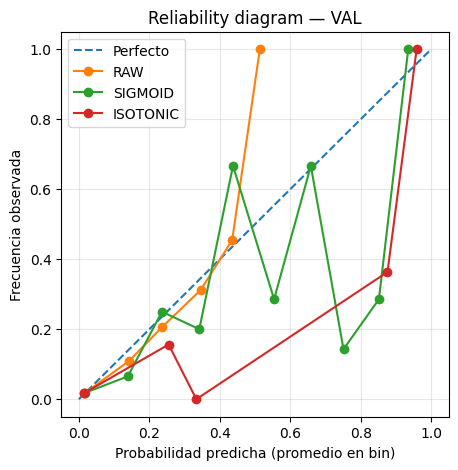

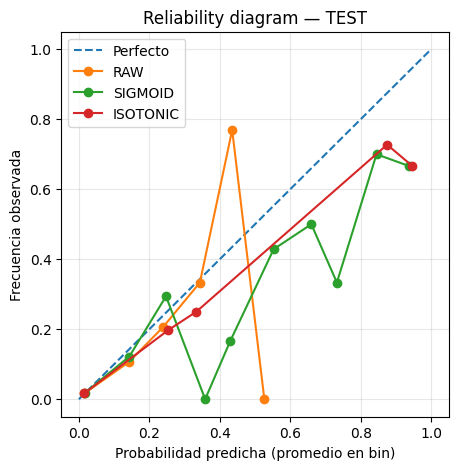

VAL: prev=0.0201 | mean(p_raw)=0.0195 | mean(p_sig)=0.0198
TEST: prev=0.0200 | mean(p_raw)=0.0192 | mean(p_sig)=0.0196


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression

# =========================================================
# 1) Calibración Platt (sigmoid) con el modelo ya entrenado
# =========================================================
cal_sig = CalibratedClassifierCV(estimator=base_model, method="sigmoid", cv="prefit")
cal_sig.fit(X_cal, y_cal)

# Probabilidades SIN calibrar (modelo base)
p_val_raw  = base_model.predict_proba(X_va)[:, 1]
p_test_raw = base_model.predict_proba(X_te)[:, 1]

# Probabilidades calibradas con SIGMOIDE
p_val_sig  = cal_sig.predict_proba(X_va)[:, 1]
p_test_sig = cal_sig.predict_proba(X_te)[:, 1]

# =========================================================
# 2) Métricas auxiliares: ECE y slope/intercept
# =========================================================
def expected_calibration_error(y_true: np.ndarray, p_pred: np.ndarray, n_bins: int = 10) -> float:
    """Compute ECE (L1) over uniform-probability bins."""
    prob_true, prob_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="uniform")
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(p_pred, bins) - 1
    w = np.bincount(idx, minlength=n_bins).astype(float)
    w = w / (w.sum() + 1e-12)
    m = min(len(prob_true), len(w))
    return float(np.sum(w[:m] * np.abs(prob_true[:m] - prob_pred[:m])))

def calib_slope_intercept(y_true: np.ndarray, p_pred: np.ndarray) -> tuple[float, float]:
    """Calibration slope & intercept via logistic regression of y ~ logit(p).
    Ideal: slope≈1, intercept≈0.
    """
    eps = 1e-15
    p = np.clip(p_pred, eps, 1 - eps)
    logit = np.log(p / (1 - p)).reshape(-1, 1)
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit, y_true)
    slope = float(lr.coef_.ravel()[0])
    intercept = float(lr.intercept_.ravel()[0])
    return slope, intercept

def summary_metrics(y_true: np.ndarray, p: np.ndarray, label: str, n_bins: int = 10) -> dict:
    slope, intercept = calib_slope_intercept(y_true, p)
    return {
        "set": label,
        "prevalence": float(np.mean(y_true)),
        "p_mean": float(np.mean(p)),
        "AUC": float(roc_auc_score(y_true, p)),
        "Brier": float(brier_score_loss(y_true, p)),
        "LogLoss": float(log_loss(y_true, np.clip(p, 1e-15, 1-1e-15))),
        "ECE": float(expected_calibration_error(y_true, p, n_bins=n_bins)),
        "CalibSlope": slope,
        "CalibIntercept": intercept,
    }

# =========================================================
# 3) Comparativa de tablas: RAW vs SIGMOID (+ ISOTÓNICA si existe)
# =========================================================
rows = [
    summary_metrics(y_va, p_val_raw,  "VAL_raw"),
    summary_metrics(y_va, p_val_sig,  "VAL_sigmoid"),
    summary_metrics(y_te, p_test_raw, "TEST_raw"),
    summary_metrics(y_te, p_test_sig, "TEST_sigmoid"),
]

# Si ya existen variables de isotónica del paso previo, las añadimos
try:
    _ = p_val_cal, p_test_cal  # solo para chequear que existen
    rows.insert(1, summary_metrics(y_va, p_val_cal,  "VAL_isotonic"))
    rows.append(    summary_metrics(y_te, p_test_cal, "TEST_isotonic"))
except NameError:
    pass

df_report_sig = pd.DataFrame(rows).round(4)
print(df_report_sig)

# =========================================================
# 4) Reliability diagrams: RAW vs SIGMOID (y ISOTÓNICA si está)
# =========================================================
def plot_reliability(y_true, preds_dict: dict, title: str, n_bins: int = 10):
    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], linestyle="--", label="Perfecto")
    for name, p in preds_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="uniform")
        plt.plot(prob_pred, prob_true, marker="o", linewidth=1.5, label=name)
    plt.xlabel("Probabilidad predicha (promedio en bin)")
    plt.ylabel("Frecuencia observada")
    plt.title(f"Reliability diagram — {title}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# VALIDACIÓN
preds_va = {"RAW": p_val_raw, "SIGMOID": p_val_sig}
try:
    preds_va["ISOTONIC"] = p_val_cal
except NameError:
    pass
plot_reliability(y_va, preds_va, "VAL")

# TEST
preds_te = {"RAW": p_test_raw, "SIGMOID": p_test_sig}
try:
    preds_te["ISOTONIC"] = p_test_cal
except NameError:
    pass
plot_reliability(y_te, preds_te, "TEST")

# =========================================================
# 5) Resumen corto para tu informe
# =========================================================
print(
    f"VAL: prev={y_va.mean():.4f} | mean(p_raw)={p_val_raw.mean():.4f} | "
    f"mean(p_sig)={p_val_sig.mean():.4f}"
)
print(
    f"TEST: prev={y_te.mean():.4f} | mean(p_raw)={p_test_raw.mean():.4f} | "
    f"mean(p_sig)={p_test_sig.mean():.4f}"
)


- El modelo base presenta buena calibración de fábrica. 
- La calibración isotónica degrada el rendimiento (sobreajuste), mientras que Platt scaling mantiene métricas similares al modelo sin calibrar. 
- Por tanto, se recomienda mantener el modelo sin calibración adicional, o en su defecto usar sigmoide por consistencia metodológica.

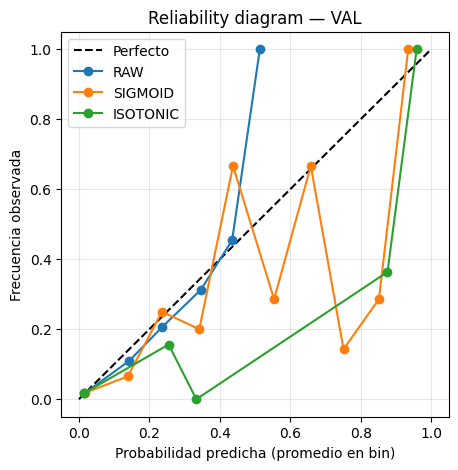

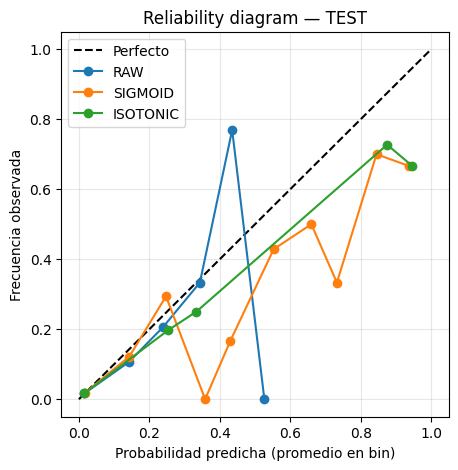

In [162]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_reliability_multi(y_true, preds_dict: dict, title: str, n_bins: int = 10):
    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], "k--", label="Perfecto")
    for name, p in preds_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="uniform")
        plt.plot(prob_pred, prob_true, marker="o", linewidth=1.5, label=name)
    plt.xlabel("Probabilidad predicha (promedio en bin)")
    plt.ylabel("Frecuencia observada")
    plt.title(f"Reliability diagram — {title}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# VAL
preds_va = {
    "RAW": p_val_raw,
    "SIGMOID": p_val_sig,
    "ISOTONIC": p_val_cal
}
plot_reliability_multi(y_va, preds_va, "VAL")

# TEST
preds_te = {
    "RAW": p_test_raw,
    "SIGMOID": p_test_sig,
    "ISOTONIC": p_test_cal
}
plot_reliability_multi(y_te, preds_te, "TEST")


# Calibracion Sigmoid

✔ Probabilidades calibradas listas: p_val_cal, p_test_cal
{'auc_raw': np.float64(0.6773680298483815), 'ap_raw': np.float64(0.12001417441289611), 'brier_raw': np.float64(0.018813705919299862), 'ece_raw': 0.0017793184924345844, 'auc_cal': np.float64(0.6773680298483815), 'ap_cal': np.float64(0.12001417441289611), 'brier_cal': np.float64(0.019122132070471802), 'ece_cal': 0.003429388444703982}


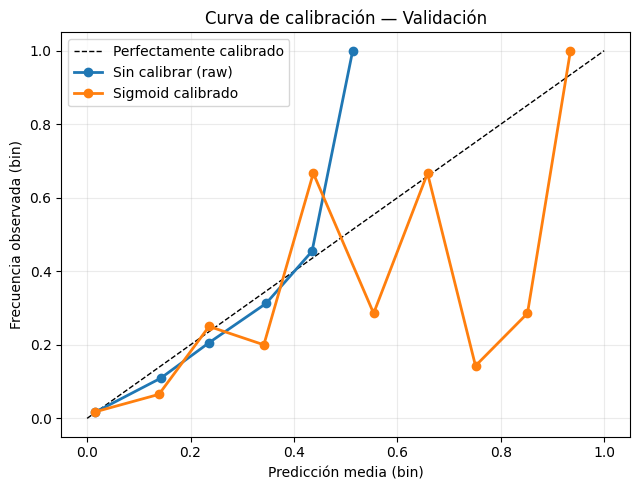

In [163]:
# =========================================
# Calibración SIGMOID (Platt) + Evaluación de calibración
# - Usa cv="prefit" para NO reentrenar XGBoost
# - Reserva 20% de TRAIN como set de calibración
# - Evalúa: Brier score (↓ mejor), curva de calibración y ECE (↓ mejor)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedShuffleSplit

from utils import model_training as mt
import importlib; importlib.reload(mt)

# ---- 1) Holdout de calibración (20% de TRAIN) ----
y_tr_1d = mt.to_1d_series(y_tr)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx_fit, idx_cal = next(sss.split(X_tr, y_tr_1d))
X_cal, y_cal = X_tr.iloc[idx_cal], y_tr_1d.iloc[idx_cal]

# ---- 2) Calibrador SIGMOID sobre modelo ya entrenado ----
# OJO: en sklearn recientes el argumento es 'estimator' (no 'base_estimator')
calibrated_clf = CalibratedClassifierCV(estimator=base_model, method="sigmoid", cv="prefit")
calibrated_clf.fit(X_cal, y_cal)

# ---- 3) Probabilidades (raw vs calibradas) en VALIDACIÓN/TEST ----
p_val_raw  = base_model.predict_proba(X_va)[:, 1]
p_test_raw = base_model.predict_proba(X_te)[:, 1]

p_val_cal  = calibrated_clf.predict_proba(X_va)[:, 1]
p_test_cal = calibrated_clf.predict_proba(X_te)[:, 1]

print("✔ Probabilidades calibradas listas: p_val_cal, p_test_cal")

# ---- 4) Función ECE (Expected Calibration Error) ----
def expected_calibration_error(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    """ECE con bins uniformes en probabilidad [0,1]."""
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = len(y_true)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (y_prob >= lo) & (y_prob < hi) if i < n_bins - 1 else (y_prob >= lo) & (y_prob <= hi)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)  # peso por frecuencia del bin
    return float(ece)

# ---- 5) Métricas de calibración en VALIDACIÓN ----
brier_raw = brier_score_loss(y_va, p_val_raw)
brier_cal = brier_score_loss(y_va, p_val_cal)
ece_raw   = expected_calibration_error(y_va, p_val_raw, n_bins=10)
ece_cal   = expected_calibration_error(y_va, p_val_cal, n_bins=10)

print({
    "auc_raw":  roc_auc_score(y_va, p_val_raw),
    "ap_raw":   average_precision_score(y_va, p_val_raw),
    "brier_raw": brier_raw,
    "ece_raw":   ece_raw,
    "auc_cal":  roc_auc_score(y_va, p_val_cal),
    "ap_cal":   average_precision_score(y_va, p_val_cal),
    "brier_cal": brier_cal,
    "ece_cal":   ece_cal,
})

# ---- 6) Curva de calibración (reliability diagram) en VALIDACIÓN ----
prob_true_raw, prob_pred_raw = calibration_curve(y_va, p_val_raw, n_bins=10, strategy="uniform")
prob_true_cal, prob_pred_cal = calibration_curve(y_va, p_val_cal, n_bins=10, strategy="uniform")

plt.figure(figsize=(6.5, 5))
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Perfectamente calibrado")
plt.plot(prob_pred_raw, prob_true_raw, marker="o", lw=2, label="Sin calibrar (raw)")
plt.plot(prob_pred_cal, prob_true_cal, marker="o", lw=2, label="Sigmoid calibrado")
plt.xlabel("Predicción media (bin)")
plt.ylabel("Frecuencia observada (bin)")
plt.title("Curva de calibración — Validación")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ---- 7) Guardar objetos si quieres reutilizar la calibración ----
# import joblib
# joblib.dump(calibrated_clf, DATA_PATH / "models" / "calibrated_sigmoid_prefit.joblib")


## Conclusion
Avanzaremos sin calibracion

# Escenarios prespuesto
- Forma de seleccionar a quien enviar

In [164]:
# 1) Reconstruye los mismos splits (mismo random_state y estratificación)

var_target = 'anula'
vars_key=['id_poliza']


vars_flag=['anul_flag_gestion_multas', # gestion_multas_
           'anul_flag_vehiculo_sustitucion', #Viene de garantia_ampliada_norm
           'anul_flag_tipo_pago_anual'] #Viene de tipo_pago_norm


vars_num_socio = [c for c in  df_muestra_vars_eng.columns if c.startswith("socio_")]
vars_num_anul = [c for c in  df_muestra_vars_eng.columns if c.startswith("anul_")]

vars_total=vars_key+[var_target]+vars_num_socio+vars_num_anul

assert len(vars_total)==len(df_muestra_vars_eng.columns), "Faltan variables"

df_muestra_vars_eng.rename(columns={'anula': 'target'}, inplace=True)

if "anula" in vars_total:
    idx = vars_total.index("anula")
    vars_total[idx] = "target"



In [165]:
# ============================================================
# Reconstruir splits y alinear beneficio_pos con X_val / X_test
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


df = df_muestra_vars_eng.copy()
assert {"target", "id_poliza", "anul_prima", "anul_importe_siniestros"} <= set(df.columns)

df_train, df_temp = train_test_split(
    df, test_size=0.40, stratify=df["target"], random_state=42
)
df_test_full, df_val_full = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp["target"], random_state=42
)

# 2) Resetea índices para que el orden posicional coincida con el que usaste al guardar X_*
df_val_reset = df_val_full.reset_index(drop=True)
df_test_reset = df_test_full.reset_index(drop=True)

# 3) Construye beneficio y beneficio_pos por posición (val/test)
benef_val  = pd.to_numeric(df_val_reset["anul_prima"], errors="coerce").astype(float) \
             - pd.to_numeric(df_val_reset["anul_importe_siniestros"], errors="coerce").astype(float)
benef_val_pos = benef_val.clip(lower=0.0)

benef_test  = pd.to_numeric(df_test_reset["anul_prima"], errors="coerce").astype(float) \
              - pd.to_numeric(df_test_reset["anul_importe_siniestros"], errors="coerce").astype(float)
benef_test_pos = benef_test.clip(lower=0.0)

# 4) Sanity check de longitudes (deben coincidir con X_va / X_te)
assert len(benef_val_pos)  == len(X_va),  "Longitud beneficio_val no coincide con X_val"
assert len(benef_test_pos) == len(X_te),  "Longitud beneficio_test no coincide con X_test"

In [166]:
# ============================================================
# PASO 2 — Escenarios de presupuesto + EPC con distintos uplift (SIN calibración)
# ============================================================
UNIT_COST = 50.0
BUDGETS   = [20_000.0, 50_000.0, 100_000.0]   # conservador/medio/agresivo
UPLIFTS   = [0.05, 0.10, 0.15, 0.20, 0.30, 0.50]

# Probabilidades RAW del modelo base
p_val_raw  = base_model.predict_proba(X_va)[:, 1]
p_test_raw = base_model.predict_proba(X_te)[:, 1]

In [167]:
def scenario_tables(p: np.ndarray,
                    benef_pos: pd.Series | np.ndarray,
                    budgets, uplifts,
                    unit_cost: float = 50.0) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Devuelve dos tablas de escenarios EPC:
    - Estricto: selecciona solo clientes con EPC > 0
    - Relajado: selecciona siempre top-k clientes según EPC ordenado, aunque EPC < 0
    """
    df = pd.DataFrame({"p_churn": np.asarray(p, float),
                       "beneficio_pos": np.asarray(benef_pos, float)})
    rows_strict, rows_relaxed = [], []

    for u in uplifts:
        epc = df["p_churn"] * u * df["beneficio_pos"] - unit_cost
        order = np.argsort(-epc.values)  # descendente
        epc_sorted = epc.values[order]
        p_sorted   = df["p_churn"].values[order]
        b_sorted   = df["beneficio_pos"].values[order]

        for B in budgets:
            k = int(B // unit_cost)

            # --- Escenario estricto ---
            mask_pos = epc_sorted > 0
            epc_pos, p_pos, b_pos = epc_sorted[mask_pos], p_sorted[mask_pos], b_sorted[mask_pos]
            take = min(k, epc_pos.shape[0])
            epc_take, p_take, b_take = epc_pos[:take], p_pos[:take], b_pos[:take]

            n = int(take)
            cost = n * unit_cost
            exp_retained = float(np.sum(p_take * u))
            exp_benefit  = float(np.sum(p_take * u * b_take))
            roi = (exp_benefit - cost) / cost if cost > 0 else np.nan
            rows_strict.append(dict(
                uplift=u, budget=B, selected=n, cost=cost,
                expected_retained=exp_retained,
                expected_benefit=exp_benefit,
                expected_roi=roi
            ))

            # --- Escenario relajado ---
            epc_take, p_take, b_take = epc_sorted[:k], p_sorted[:k], b_sorted[:k]
            n_rel = int(len(epc_take))
            cost_rel = n_rel * unit_cost
            exp_retained_rel = float(np.sum(p_take * u))
            exp_benefit_rel  = float(np.sum(p_take * u * b_take))
            roi_rel = (exp_benefit_rel - cost_rel) / cost_rel if cost_rel > 0 else np.nan
            rows_relaxed.append(dict(
                uplift=u, budget=B, selected=n_rel, cost=cost_rel,
                expected_retained=exp_retained_rel,
                expected_benefit=exp_benefit_rel,
                expected_roi=roi_rel
            ))

    df_strict  = pd.DataFrame(rows_strict).sort_values(["uplift","budget"]).reset_index(drop=True)
    df_relaxed = pd.DataFrame(rows_relaxed).sort_values(["uplift","budget"]).reset_index(drop=True)
    return df_strict, df_relaxed


In [168]:
# === VALIDACIÓN ===
scen_val_strict, scen_val_relaxed = scenario_tables(
    p=p_val_raw,
    benef_pos=benef_val_pos,
    budgets=BUDGETS,
    uplifts=UPLIFTS,
    unit_cost=UNIT_COST,
)
print("Escenarios — VALIDACIÓN (estricto)")
display(scen_val_strict)
print("\nEscenarios — VALIDACIÓN (relajado)")
display(scen_val_relaxed)

# === TEST ===
scen_test_strict, scen_test_relaxed = scenario_tables(
    p=p_test_raw,
    benef_pos=benef_test_pos,
    budgets=BUDGETS,
    uplifts=UPLIFTS,
    unit_cost=UNIT_COST,
)
print("\nEscenarios — TEST (estricto)")
display(scen_test_strict)
print("\nEscenarios — TEST (relajado)")
display(scen_test_relaxed)


Escenarios — VALIDACIÓN (estricto)


,uplift,budget,selected,cost,expected_retained,expected_benefit,expected_roi
0,0.05,20000.0,0,0.0,0.000000,0.000000,NaN
1,0.05,50000.0,0,0.0,0.000000,0.000000,NaN
2,0.05,100000.0,0,0.0,0.000000,0.000000,NaN
3,0.10,20000.0,0,0.0,0.000000,0.000000,NaN
4,0.10,50000.0,0,0.0,0.000000,0.000000,NaN
5,0.10,100000.0,0,0.0,0.000000,0.000000,NaN
6,0.15,20000.0,1,50.0,0.053532,50.143706,0.002874
7,0.15,50000.0,1,50.0,0.053532,50.143706,0.002874
8,0.15,100000.0,1,50.0,0.053532,50.143706,0.002874
9,0.20,20000.0,2,100.0,0.134919,121.786947,0.217869



Escenarios — VALIDACIÓN (relajado)


,uplift,budget,selected,cost,expected_retained,expected_benefit,expected_roi
0,0.05,20000.0,400,20000.0,1.618709,856.440289,-0.957178
1,0.05,50000.0,1000,50000.0,2.524446,1302.528488,-0.973949
2,0.05,100000.0,2000,100000.0,3.576760,1763.149833,-0.982369
3,0.10,20000.0,400,20000.0,3.237419,1712.880577,-0.914356
4,0.10,50000.0,1000,50000.0,5.048891,2605.056976,-0.947899
5,0.10,100000.0,2000,100000.0,7.153520,3526.299666,-0.964737
6,0.15,20000.0,400,20000.0,4.856128,2569.320866,-0.871534
7,0.15,50000.0,1000,50000.0,7.573337,3907.585464,-0.921848
8,0.15,100000.0,2000,100000.0,10.730280,5289.449499,-0.947106
9,0.20,20000.0,400,20000.0,6.474838,3425.761154,-0.828712



Escenarios — TEST (estricto)


,uplift,budget,selected,cost,expected_retained,expected_benefit,expected_roi
0,0.05,20000.0,0,0.0,0.000000,0.000000,NaN
1,0.05,50000.0,0,0.0,0.000000,0.000000,NaN
2,0.05,100000.0,0,0.0,0.000000,0.000000,NaN
3,0.10,20000.0,0,0.0,0.000000,0.000000,NaN
4,0.10,50000.0,0,0.0,0.000000,0.000000,NaN
5,0.10,100000.0,0,0.0,0.000000,0.000000,NaN
6,0.15,20000.0,1,50.0,0.057599,73.726662,0.474533
7,0.15,50000.0,1,50.0,0.057599,73.726662,0.474533
8,0.15,100000.0,1,50.0,0.057599,73.726662,0.474533
9,0.20,20000.0,3,150.0,0.245301,203.550050,0.357000



Escenarios — TEST (relajado)


,uplift,budget,selected,cost,expected_retained,expected_benefit,expected_roi
0,0.05,20000.0,400,20000.0,1.642316,837.252819,-0.958137
1,0.05,50000.0,1000,50000.0,2.577968,1266.406160,-0.974672
2,0.05,100000.0,2000,100000.0,3.596621,1711.037660,-0.982890
3,0.10,20000.0,400,20000.0,3.284633,1674.505637,-0.916275
4,0.10,50000.0,1000,50000.0,5.155935,2532.812320,-0.949344
5,0.10,100000.0,2000,100000.0,7.193241,3422.075319,-0.965779
6,0.15,20000.0,400,20000.0,4.926949,2511.758456,-0.874412
7,0.15,50000.0,1000,50000.0,7.733903,3799.218479,-0.924016
8,0.15,100000.0,2000,100000.0,10.789862,5133.112979,-0.948669
9,0.20,20000.0,400,20000.0,6.569266,3349.011275,-0.832549


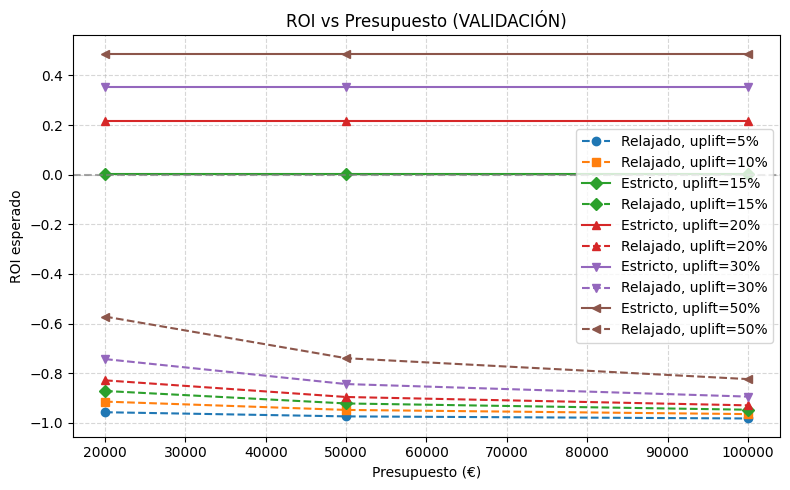

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def plot_roi_curves(df_strict, df_relaxed, title="ROI vs Presupuesto"):
    """Grafica ROI esperado en escenarios estricto vs relajado para cualquier conjunto de uplifts."""
    # Uplifts únicos (como float "normal" para evitar np.float64 como clave)
    uplifts = [float(u) for u in sorted(df_strict["uplift"].unique())]

    # Ciclos de estilos
    color_cyc   = cycle(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"])
    marker_cyc  = cycle(["o","s","D","^","v","<",">","P","X","*"])

    # Mapeos por uplift
    color_map  = {u: next(color_cyc) for u in uplifts}
    marker_map = {u: next(marker_cyc) for u in uplifts}

    plt.figure(figsize=(8,5))
    for u in uplifts:
        d_strict  = df_strict[df_strict["uplift"].astype(float)==u].sort_values("budget")
        d_relaxed = df_relaxed[df_relaxed["uplift"].astype(float)==u].sort_values("budget")

        # Filtra NaN en ROI si los hubiera
        ds = d_strict.dropna(subset=["expected_roi"])
        dr = d_relaxed.dropna(subset=["expected_roi"])

        # Estricto: línea continua
        if not ds.empty:
            plt.plot(ds["budget"], ds["expected_roi"],
                     marker=marker_map[u], linestyle="-", color=color_map[u],
                     label=f"Estricto, uplift={u:.0%}")

        # Relajado: línea discontinua (mismo color)
        if not dr.empty:
            plt.plot(dr["budget"], dr["expected_roi"],
                     marker=marker_map[u], linestyle="--", color=color_map[u],
                     label=f"Relajado, uplift={u:.0%}")

    plt.axhline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Presupuesto (€)")
    plt.ylabel("ROI esperado")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso:
plot_roi_curves(scen_val_strict, scen_val_relaxed, title="ROI vs Presupuesto (VALIDACIÓN)")



1. **Escenarios con uplift bajo (5%–10%)**
    - Todas las curvas están por debajo de 0 (ROI negativo).
    - Significa que si asumimos que solo el **5–10%** de los clientes contactados cambian su decisión gracias al incentivo, **la campaña no se rentabiliza**: se gasta más en incentivos de lo que se recupera en beneficios.
2. **Uplift medio (15%)**
    - **Escenario estricto** (solo clientes con EPC > 0) está justo en ROI ≈ 0.
    - Esto implica que **el break-even está en torno a 15%**: si realmente el incentivo recupera a un 15% de los contactados, la campaña empieza a dejar de perder dinero.
3. **Uplift más alto (20–30%)**
    - ROI positivo (entre +20% y +40%).
    - Aquí sí hay beneficio esperado, sobre todo si somos selectivos (estricto).
    - A mayor presupuesto, la curva tiende a bajar un poco (porque empiezas a contactar clientes con menos EPC positivo).
4. **Uplift muy alto (50%)**
    - ROI muy alto (≈ +50%).
    - Claramente rentable en cualquier presupuesto, pero **probablemente irrealista** para un incentivo de €50 en seguros de autos (es raro que 1 de cada 2 clientes cambie solo por el incentivo).

# Punto de corte teorico

In [170]:
# ============================================================
# Selección de punto de corte (sin calibración, aún)
# - Candidatos: Youden, Máx-F0.5 (precisión-primero), y
#   "precisión mínima + máx recall" para varios niveles (20/30/40%)
# - Tabla con métricas por threshold en una grilla fina
# ============================================================

In [171]:
# Asegura que usamos las mismas columnas/orden del entrenamiento
if hasattr(base_model, "feature_names_in_"):
    used_feats = list(base_model.feature_names_in_)
else:
    # si guardaste la lista en otro lado (p.ej. results.used_features), cárgala aquí
    raise ValueError("No encuentro feature_names_in_. Carga la lista de features usada en entrenamiento.")

# OJO a los nombres de tus variables: entrenaste con X_tr/X_va/X_te (no X_val/X_test)
Xva_aligned = X_va[used_feats].copy()
Xte_aligned = X_te[used_feats].copy()

# (opcional) asegurar tipos numéricos
Xva_aligned = Xva_aligned.apply(pd.to_numeric, errors="coerce")
Xte_aligned = Xte_aligned.apply(pd.to_numeric, errors="coerce")

# Probabilidades (sin calibración)
p_val = base_model.predict_proba(Xva_aligned)[:, 1]
p_test = base_model.predict_proba(Xte_aligned)[:, 1]

# Targets 1D
y_va_1d = mt.to_1d_series(y_val)
y_te_1d = mt.to_1d_series(y_test)

# --- Selección de punto de corte precision-first ---
qs = np.linspace(0.99, 0.01, 200)
grid_thr = np.unique(np.quantile(p_val, qs))

rep_prec_first = mt.select_threshold_max_recall(
    y_true=y_va_1d,
    y_proba=p_val,
    min_precision=0.30,
    grid=grid_thr
)

if rep_prec_first is None:
    rep_f05 = mt.select_threshold_by_fbeta(y_va_1d, p_val, beta=0.5)
    chosen_thr = float(rep_f05.threshold); chosen_label = "maxF0.5 (fallback)"
    rep_val = rep_f05
else:
    chosen_thr = float(rep_prec_first.threshold); chosen_label = "max recall @ prec≥30%"
    rep_val = rep_prec_first

print(f"\n✅ Corte elegido: {chosen_label} = {chosen_thr:.4f}")
print("VAL @ corte:", asdict(rep_val))

# Eval en TEST con mismas columnas/orden
rep_test = mt.threshold_metrics(y_true=y_te_1d, y_proba=p_test, threshold=chosen_thr, beta=1.0)
print("\n▶ TEST @ corte:", asdict(rep_test))



✅ Corte elegido: maxF0.5 (fallback) = 0.2000
VAL @ corte: {'threshold': 0.2, 'precision': 0.3125, 'recall': 0.10471204188481675, 'fbeta': 0.22371364653243847, 'support_pos': 191, 'positives_pred': 64}

▶ TEST @ corte: {'threshold': 0.2, 'precision': 0.3492063492063492, 'recall': 0.11578947368421053, 'fbeta': 0.17391304347826086, 'support_pos': 190, 'positives_pred': 63}
